<a href="https://colab.research.google.com/github/mrutherfoord/AIC-Photo-Match/blob/master/AIC_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import boto3
from botocore.exceptions import NoCredentialsError

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# AWS access keys HIDE THESE!!
ACCESS_KEY = '***************************'
SECRET_KEY = '***************************'

In [0]:
# Function to upload to an AWS bucket
def upload_to_aws(local_file, bucket, s3_file):
  '''Upload a file to an AWS S3 bucket'''
  s3 = boto3.client('s3', aws_access_key_id=ACCESS_KEY,
                      aws_secret_access_key=SECRET_KEY)

  try:
    s3.upload_file(local_file, bucket, s3_file)
    print("Upload Successful")
    return True
  except FileNotFoundError:
    print("The file was not found")
    return False
  except NoCredentialsError:
    print("Credentials not available")
    return False

In [0]:
# Testing function to upload to an AWS bucket
upload_to_aws('sample_data/README.md', 'mrutherfoordtestbucket', 'test')

Upload Successful


True

In [0]:
# importing modules for gathering API data
import requests
import json

In [0]:
# testing the images endpoint from the AIC API
aic_url = "https://api.artic.edu/api/v1/images"
response = requests.get(aic_url)
print(response.status_code)

200


In [0]:
# pull all data from AIC API images endpoint
aic_full = response.json()
aic_images = aic_full["data"]
while aic_full["pagination"]["next_url"]:
  try:
    aic_full = requests.get(aic_full["pagination"]["next_url"]).json()
    aic_images.extend(aic_full["data"])
    if aic_full["pagination"]["current_page"] % 100 == 0:
      print(f'Current Page is {aic_full["pagination"]["current_page"]}')
  except KeyError:
    break

In [0]:
# length of dictionary
print(len(aic_images))

141596


In [0]:
# export AIC API image data to csv
import csv
keys = aic_images[0].keys()
with open('aic_api_images_json.csv', 'w') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(aic_images)

In [0]:
# the fields for the image endpoint don't describe the type of art and some other data I'd like to have
# using the artworks endpoint to find more information about the pieces
# testing the images endpoint from the AIC API
aic_url = "https://api.artic.edu/api/v1/artworks?fields=id,classification_titles,classification_ids,artist_titles,artist_ids&limit=50"
response = requests.get(aic_url)
print(response.status_code)

200


In [0]:
# pull all data from AIC API artworks endpoint
aic_artworks_full = response.json()
aic_artworks = aic_artworks_full["data"]
while aic_artworks_full["pagination"]["next_url"]:
  aic_artworks_full = requests.get(aic_artworks_full["pagination"]["next_url"]).json()
  aic_artworks.extend(aic_artworks_full["data"])
  if aic_artworks_full["pagination"]["current_page"] % 100 == 0:
    print(f'Current Page is {aic_artworks_full["pagination"]["current_page"]}')
    break 

Current Page is 100


In [0]:
js = json.dumps(aic_artworks)

In [0]:
import pandas as pd
js_df = pd.read_json(js)

In [0]:
js_df

,id,artist_ids,artist_titles,classification_ids,classification_titles
0,145137,[35776],[Sir John Everett Millais],"[TM-5, TM-175, TM-4]","[drawings (visual works), graphite, prints and..."
1,112280,[37300],[David Wilkie],"[TM-5, TM-212, TM-4]","[drawings (visual works), pen and ink drawings..."
2,241242,[50578],[Fon],"[TM-13486, TM-12318, TM-12858, TM-12923]","[african art, ritual objects, altar, altar obj..."
3,239462,"[30150, 116308]","[Makonde, Diteka]","[TM-2332, TM-245, TM-13486, TM-12149]","[headdress - misc, masks, african art, ceremon..."
4,83889,[33229],[Willem de Kooning],"[TM-5, TM-229, TM-4]","[drawings (visual works), pastel, prints and d..."
...,...,...,...,...,...
4995,113218,[36289],[Augustus Charles Pugin],"[TM-5, TM-175, TM-4]","[drawings (visual works), graphite, prints and..."
4996,113217,[36289],[Augustus Charles Pugin],"[TM-5, TM-175, TM-4]","[drawings (visual works), graphite, prints and..."
4997,113228,[36289],[Augustus Charles Pugin],"[TM-5, TM-175, TM-4]","[drawings (visual works), graphite, prints and..."
4998,113226,[36289],[Augustus Charles Pugin],"[TM-5, TM-212, TM-4]","[drawings (visual works), pen and ink drawings..."


In [0]:
f = lambda x: 'artist_ids_{}'.format(x + 1)
js_artist_ids = pd.DataFrame(
    js_df.artist_ids.values.tolist(),
    js_df.index, dtype=object
).fillna('').rename(columns=f)

In [0]:
js_df.drop(['artist_ids'], axis=1, inplace=True)

In [0]:
dataframes = [js_df, js_artist_ids]
df_new = pd.concat(dataframes, axis=1)
df_new

,id,artist_titles,classification_ids,classification_titles,artist_ids_1,artist_ids_2
0,145137,[Sir John Everett Millais],"[TM-5, TM-175, TM-4]","[drawings (visual works), graphite, prints and...",35776,
1,112280,[David Wilkie],"[TM-5, TM-212, TM-4]","[drawings (visual works), pen and ink drawings...",37300,
2,241242,[Fon],"[TM-13486, TM-12318, TM-12858, TM-12923]","[african art, ritual objects, altar, altar obj...",50578,
3,239462,"[Makonde, Diteka]","[TM-2332, TM-245, TM-13486, TM-12149]","[headdress - misc, masks, african art, ceremon...",30150,116308
4,83889,[Willem de Kooning],"[TM-5, TM-229, TM-4]","[drawings (visual works), pastel, prints and d...",33229,
...,...,...,...,...,...,...
4995,113218,[Augustus Charles Pugin],"[TM-5, TM-175, TM-4]","[drawings (visual works), graphite, prints and...",36289,
4996,113217,[Augustus Charles Pugin],"[TM-5, TM-175, TM-4]","[drawings (visual works), graphite, prints and...",36289,
4997,113228,[Augustus Charles Pugin],"[TM-5, TM-175, TM-4]","[drawings (visual works), graphite, prints and...",36289,
4998,113226,[Augustus Charles Pugin],"[TM-5, TM-212, TM-4]","[drawings (visual works), pen and ink drawings...",36289,


In [0]:
# export AIC API artworks data to csv
import csv
keys = aic_artworks[0].keys()
with open('aic_api_artworks_json.csv', 'w') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(aic_artworks)

In [0]:
# import images and artwork csvs to pandas dataframe
import pandas as pd
images_df = pd.read_csv('drive/My Drive/Colab Notebooks/aic_api_images_json.csv', usecols=['id','iiif_url', 'artwork_ids', 'artwork_titles'])
artworks_df = pd.read_csv('drive/My Drive/Colab Notebooks/aic_api_artworks_json.csv')

Visually, it looked like the method worked for successfully pulling the data I needed and converting it to dataframes, but when I went to separate the values that are in lists to separate columns, they were not in lists, but counted as a single object. If I ran something like len(df.col[0][0]) for ['TM-5'] it would return 8 instead of 1. So I decided I needed to run my code again and put the resulting JSON into a dataframe immediately before saving to a .csv format.

# Second Attempt at Getting AIC API DATA

In [0]:
# importing modules for gathering API data
import requests
import json

# modules for data cleaning
import pandas as pd

In [0]:
# testing the images endpoint from the AIC API with the specific fields I need
aic_images_url = "https://aggregator-data.artic.edu/api/v1/images?fields=id,iiif_url,artwork_ids,artwork_titles&limit=50"
response = requests.get(aic_images_url)
print(response.status_code)

200


In [0]:
# pull all data from AIC API images endpoint
aic_full = response.json()
aic_images = aic_full["data"]
while aic_full["pagination"]["next_url"]:
  try:
    aic_full = requests.get(aic_full["pagination"]["next_url"]).json()
    aic_images.extend(aic_full["data"])
    if aic_full["pagination"]["current_page"] % 100 == 0:
      print(f'Current Page is {aic_full["pagination"]["current_page"]}')
  except KeyError:
    aic_full["pagination"]["next_url"] = False

In [0]:
# making sure the data is in json and converting it to a dataframe
aic_img_json = json.dumps(aic_images)
aic_img_df = pd.read_json(aic_img_json)

In [0]:
aic_img_df

,id,iiif_url,artwork_ids,artwork_titles
0,ece84e75-d26f-eb5f-e641-ef4946ee3a1e,https://www.artic.edu/iiif/2/ece84e75-d26f-eb5...,[115407],[Mill (recto); Tree (verso)]
1,c14a072b-be3c-1d94-030c-1eee4cbd5e11,https://www.artic.edu/iiif/2/c14a072b-be3c-1d9...,[112708],[Raising of Lazarus (recto); Travelers with Ca...
2,bef42115-82f7-e406-439d-98f4ab21817c,https://www.artic.edu/iiif/2/bef42115-82f7-e40...,[93805],[I Walk To and Fro through Civilization and I ...
3,7420ca52-33c8-6a71-d0db-0f5d180251c4,https://www.artic.edu/iiif/2/7420ca52-33c8-6a7...,[112708],[Raising of Lazarus (recto); Travelers with Ca...
4,4a3519e1-6cd1-9b18-a3ac-4b2e2a91c622,https://www.artic.edu/iiif/2/4a3519e1-6cd1-9b1...,[41159],[The Crucifixion with the Virgin and St. John ...
...,...,...,...,...
141657,f243ae62-a993-9c7e-a2a2-5808d418d960,https://www.artic.edu/iiif/2/f243ae62-a993-9c7...,[251284],[Untitled (Brand Markings)]
141658,5f52b25e-12da-d2dd-81cc-d1ab480df575,https://www.artic.edu/iiif/2/5f52b25e-12da-d2d...,[251387],"[Project for Panel, Erie Street, Chicago]"
141659,be00506e-234a-ecaf-ae6c-7728723d8e69,https://www.artic.edu/iiif/2/be00506e-234a-eca...,[251386],"[Project for Panel, Sam’s, Chicago]"
141660,cc7dee5b-921f-e84e-cced-2b321d04b258,https://www.artic.edu/iiif/2/cc7dee5b-921f-e84...,[251291],[Roman Berry]


This next section separates the list of columns into their own columns. I decided to only keep the first id and title.

In [0]:
# separating artwork_ids column
f = lambda x: 'artwork_ids_{}'.format(x + 1)
img_artwork_ids = pd.DataFrame(aic_img_df.artwork_ids.values.tolist(),aic_img_df.index, dtype=object).fillna('').rename(columns=f)

In [0]:
# keeping only the first column
img_artwork_ids = img_artwork_ids['artwork_ids_1']

In [0]:
# separating the artwork_titles column
f = lambda x: 'artwork_titles_{}'.format(x + 1)
img_artwork_titles = pd.DataFrame(aic_img_df.artwork_titles.values.tolist(), aic_img_df.index, dtype=object).fillna('').rename(columns=f)

In [0]:
# keeping the first column
img_artwork_titles = img_artwork_titles['artwork_titles_1']

In [0]:
# concatenating the new columns with the original data frame and cleaning it up
aic_img_df.drop(['artwork_ids', 'artwork_titles'], axis=1, inplace=True)
newframes = [aic_img_df, img_artwork_ids, img_artwork_titles]
aic_img_final_df = pd.concat(newframes, axis=1)

In [0]:
aic_img_final_df

,id,iiif_url,artwork_ids_1,artwork_titles_1
0,ece84e75-d26f-eb5f-e641-ef4946ee3a1e,https://www.artic.edu/iiif/2/ece84e75-d26f-eb5...,115407,Mill (recto); Tree (verso)
1,c14a072b-be3c-1d94-030c-1eee4cbd5e11,https://www.artic.edu/iiif/2/c14a072b-be3c-1d9...,112708,Raising of Lazarus (recto); Travelers with Car...
2,bef42115-82f7-e406-439d-98f4ab21817c,https://www.artic.edu/iiif/2/bef42115-82f7-e40...,93805,I Walk To and Fro through Civilization and I T...
3,7420ca52-33c8-6a71-d0db-0f5d180251c4,https://www.artic.edu/iiif/2/7420ca52-33c8-6a7...,112708,Raising of Lazarus (recto); Travelers with Car...
4,4a3519e1-6cd1-9b18-a3ac-4b2e2a91c622,https://www.artic.edu/iiif/2/4a3519e1-6cd1-9b1...,41159,The Crucifixion with the Virgin and St. John (...
...,...,...,...,...
141657,f243ae62-a993-9c7e-a2a2-5808d418d960,https://www.artic.edu/iiif/2/f243ae62-a993-9c7...,251284,Untitled (Brand Markings)
141658,5f52b25e-12da-d2dd-81cc-d1ab480df575,https://www.artic.edu/iiif/2/5f52b25e-12da-d2d...,251387,"Project for Panel, Erie Street, Chicago"
141659,be00506e-234a-ecaf-ae6c-7728723d8e69,https://www.artic.edu/iiif/2/be00506e-234a-eca...,251386,"Project for Panel, Sam’s, Chicago"
141660,cc7dee5b-921f-e84e-cced-2b321d04b258,https://www.artic.edu/iiif/2/cc7dee5b-921f-e84...,251291,Roman Berry


In [0]:
# saving to .csv
aic_img_final_df.to_csv('images_endpoint.csv')

In [0]:
# the fields for the image endpoint don't describe the type of art and some other data I'd like to have
# using the artworks endpoint to find more information about the pieces
# testing the images endpoint from the AIC API
aic_url = "https://api.artic.edu/api/v1/artworks?fields=id,classification_titles,classification_ids,artist_titles,artist_ids&limit=50"
response = requests.get(aic_url)
print(response.status_code)

200


In [0]:
# pull all data from AIC API artworks endpoint
aic_artworks_full = response.json()
aic_artworks = aic_artworks_full["data"]
while aic_artworks_full["pagination"]["next_url"]:
  aic_artworks_full = requests.get(aic_artworks_full["pagination"]["next_url"]).json()
  aic_artworks.extend(aic_artworks_full["data"])
  if aic_artworks_full["pagination"]["current_page"] % 100 == 0:
    print(f'Current Page is {aic_artworks_full["pagination"]["current_page"]}')

In [0]:
# making sure the data is in json and converting it to a dataframe
aic_artworks_json = json.dumps(aic_artworks)
aic_artworks_df = pd.read_json(aic_artworks_json)

In [0]:
aic_artworks_df.head(5)

,id,artist_ids,artist_titles,classification_ids,classification_titles
0,56060,[36041],[Bror Julius Olsson Nordfeldt],"[TM-17, TM-4, TM-18]","[print, prints and drawing, etching]"
1,29098,[36041],[Bror Julius Olsson Nordfeldt],"[TM-17, TM-4, TM-18]","[print, prints and drawing, etching]"
2,47592,[36041],[Bror Julius Olsson Nordfeldt],"[TM-17, TM-4, TM-18]","[print, prints and drawing, etching]"
3,47440,[36041],[Bror Julius Olsson Nordfeldt],"[TM-17, TM-4, TM-18]","[print, prints and drawing, etching]"
4,134340,[37541],[Ancient Egyptian],"[TM-1392, TM-1414, TM-81]","[ancient art, scarab, costume]"


In [0]:
# separating artist_ids column
f = lambda x: 'artist_ids_{}'.format(x + 1)
art_artist_ids = pd.DataFrame(aic_artworks_df.artist_ids.values.tolist(), aic_artworks_df.index, dtype=object).fillna('').rename(columns=f)

In [0]:
# keeping only the first artist id
art_artist_ids = art_artist_ids['artist_ids_1']

In [0]:
# separating the artist_titles column
f = lambda x: 'artist_titles_{}'.format(x + 1)
art_artist_titles = pd.DataFrame(aic_artworks_df.artist_titles.values.tolist(), aic_artworks_df.index, dtype=object
                                 ).fillna('').rename(columns=f)

In [0]:
# keeping only the first artist title
art_artist_titles = art_artist_titles['artist_titles_1']

In [0]:
# class_ids will be important for filtering the art i want to use (i.e. no sculpture), so I will keep all of the columns
f = lambda x: 'class_ids_{}'.format(x + 1)
art_class_ids = pd.DataFrame(aic_artworks_df.classification_ids.values.tolist(), aic_artworks_df.index, dtype=object
                             ).fillna('').rename(columns=f)

In [0]:
art_class_ids.head(5)

,class_ids_1,class_ids_2,class_ids_3,class_ids_4,class_ids_5,class_ids_6,class_ids_7,class_ids_8,class_ids_9
0,TM-17,TM-4,TM-18,,,,,,
1,TM-17,TM-4,TM-18,,,,,,
2,TM-17,TM-4,TM-18,,,,,,
3,TM-17,TM-4,TM-18,,,,,,
4,TM-1392,TM-1414,TM-81,,,,,,


In [0]:
# separating the class_titles columns columns
f = lambda x: 'class_titles_{}'.format(x + 1)
art_class_titles = pd.DataFrame(
    aic_artworks_df.classification_titles.values.tolist(),
    aic_artworks_df.index, dtype=object
).fillna('').rename(columns=f)

In [0]:
art_class_titles.head(5)

,class_titles_1,class_titles_2,class_titles_3,class_titles_4,class_titles_5,class_titles_6,class_titles_7,class_titles_8,class_titles_9
0,print,prints and drawing,etching,,,,,,
1,print,prints and drawing,etching,,,,,,
2,print,prints and drawing,etching,,,,,,
3,print,prints and drawing,etching,,,,,,
4,ancient art,scarab,costume,,,,,,


In [0]:
# concatenating all of the new columns into the original dataframe
aic_artworks_df.drop(['artist_ids', 'artist_titles', 'classification_ids', 'classification_titles'], axis=1, inplace=True)
newframes2 = [aic_artworks_df, art_artist_ids, art_artist_titles, art_class_ids, art_class_titles]
aic_artworks_final_df = pd.concat(newframes2, axis=1)

In [0]:
aic_artworks_final_df.head()

,id,artist_ids_1,artist_titles_1,class_ids_1,class_ids_2,class_ids_3,class_ids_4,class_ids_5,class_ids_6,class_ids_7,class_ids_8,class_ids_9,class_titles_1,class_titles_2,class_titles_3,class_titles_4,class_titles_5,class_titles_6,class_titles_7,class_titles_8,class_titles_9
0,56060,36041,Bror Julius Olsson Nordfeldt,TM-17,TM-4,TM-18,,,,,,,print,prints and drawing,etching,,,,,,
1,29098,36041,Bror Julius Olsson Nordfeldt,TM-17,TM-4,TM-18,,,,,,,print,prints and drawing,etching,,,,,,
2,47592,36041,Bror Julius Olsson Nordfeldt,TM-17,TM-4,TM-18,,,,,,,print,prints and drawing,etching,,,,,,
3,47440,36041,Bror Julius Olsson Nordfeldt,TM-17,TM-4,TM-18,,,,,,,print,prints and drawing,etching,,,,,,
4,134340,37541,Ancient Egyptian,TM-1392,TM-1414,TM-81,,,,,,,ancient art,scarab,costume,,,,,,


In [0]:
# saving to csv
aic_artworks_final_df.to_csv('artworks_endpoint.csv')

# Filtering Art
Now that I have the information I need from both endpoints, I need to merge them on the artwork id, and filter the types of art I want to use for this project. 

In [0]:
# importing csv
import pandas as pd
image_df = pd.read_csv('drive/My Drive/Colab Notebooks/images_endpoint.csv')
artworks_df = pd.read_csv('drive/My Drive/Colab Notebooks/artworks_endpoint.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (12,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
# the artwork id data imported as a float, so i need to convert them to an integer
image_df['artwork_ids_1'] = image_df['artwork_ids_1'].fillna(0).astype(int)

In [0]:
# I accidentally included the index when I saved the .csv, so I need to drop it
image_df.drop('Unnamed: 0', inplace=True, axis=1)

In [0]:
image_df.head()

,id,iiif_url,artwork_ids_1,artwork_titles_1
0,ece84e75-d26f-eb5f-e641-ef4946ee3a1e,https://www.artic.edu/iiif/2/ece84e75-d26f-eb5...,115407,Mill (recto); Tree (verso)
1,c14a072b-be3c-1d94-030c-1eee4cbd5e11,https://www.artic.edu/iiif/2/c14a072b-be3c-1d9...,112708,Raising of Lazarus (recto); Travelers with Car...
2,bef42115-82f7-e406-439d-98f4ab21817c,https://www.artic.edu/iiif/2/bef42115-82f7-e40...,93805,I Walk To and Fro through Civilization and I T...
3,7420ca52-33c8-6a71-d0db-0f5d180251c4,https://www.artic.edu/iiif/2/7420ca52-33c8-6a7...,112708,Raising of Lazarus (recto); Travelers with Car...
4,4a3519e1-6cd1-9b18-a3ac-4b2e2a91c622,https://www.artic.edu/iiif/2/4a3519e1-6cd1-9b1...,41159,The Crucifixion with the Virgin and St. John (...


In [0]:
# converting artist_ids to integers
artworks_df['artist_ids_1'] = artworks_df['artist_ids_1'].fillna(0).astype(int)

In [0]:
# dropping the unnecessary index column
artworks_df.drop('Unnamed: 0', inplace=True, axis=1)

In [0]:
artworks_df.head()

,id,artist_ids_1,artist_titles_1,class_ids_1,class_ids_2,class_ids_3,class_ids_4,class_ids_5,class_ids_6,class_ids_7,class_ids_8,class_ids_9,class_titles_1,class_titles_2,class_titles_3,class_titles_4,class_titles_5,class_titles_6,class_titles_7,class_titles_8,class_titles_9
0,56060,36041,Bror Julius Olsson Nordfeldt,TM-17,TM-4,TM-18,NaN,NaN,NaN,NaN,NaN,NaN,print,prints and drawing,etching,NaN,NaN,NaN,NaN,NaN,NaN
1,29098,36041,Bror Julius Olsson Nordfeldt,TM-17,TM-4,TM-18,NaN,NaN,NaN,NaN,NaN,NaN,print,prints and drawing,etching,NaN,NaN,NaN,NaN,NaN,NaN
2,47592,36041,Bror Julius Olsson Nordfeldt,TM-17,TM-4,TM-18,NaN,NaN,NaN,NaN,NaN,NaN,print,prints and drawing,etching,NaN,NaN,NaN,NaN,NaN,NaN
3,47440,36041,Bror Julius Olsson Nordfeldt,TM-17,TM-4,TM-18,NaN,NaN,NaN,NaN,NaN,NaN,print,prints and drawing,etching,NaN,NaN,NaN,NaN,NaN,NaN
4,134340,37541,Ancient Egyptian,TM-1392,TM-1414,TM-81,NaN,NaN,NaN,NaN,NaN,NaN,ancient art,scarab,costume,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# merging the two endpoint dataframes on the artwork id field
full_df = image_df.merge(artworks_df, how='inner', left_on='artwork_ids_1', right_on='id')

In [0]:
# size of the new dataframe 
full_df.shape

(115731, 25)

Using the API, I at first tried to filter the works by only using the "painting" classification ('TM-9'), but that returned only ~3000 works, so I investigated the classification ids more closely and selected the ones that I wanted to include in this project. This includes works in ink, pastel, oil, acrylic, watercolor, and many types of prints.

In [0]:
class_ids_list = ['TM-78', 'TM-10368', 'TM-378', 'TM-10387', 'TM-1203', 'TM-54', 'TM-10424', 'TM-440', 'TM-1083',
                  'TM-11420', 'TM-1197', 'TM-10113', 'TM-10234', 'TM-13352', 'TM-258', 'TM-1374', 'TM-13768',
                  'TM-1453', 'TM-1648', 'TM-1650', 'TM-17', 'TM-214', 'TM-2172', 'TM-4', 'TM-402', 'TM-418', 'TM-420',
                  'TM-308', 'TM-750', 'TM-695', 'TM-636', 'TM-637', 'TM-679', 'TM-604', 'TM-605', 'TM-788', 'TM-799',
                  'TM-812', 'TM-824', 'TM-966', 'TM-11962', 'TM-13793', 'TM-1613', 'TM-1651', 'TM-186', 'TM-186',
                  'TM-2188', 'TM-2200', 'TM-2211', 'TM-484', 'TM-490', 'TM-387', 'TM-66', 'TM-78', 'TM-80', 'TM-39',
                  'TM-10368', 'TM-1398', 'TM-229', 'TM-482', 'TM-148', 'TM-10309', 'TM-1602', 'TM-1627', 'TM-10233',
                  'TM-1382', 'TM-1617', 'TM-1625', 'TM-10378', 'TM-1642', 'TM-212', 'TM-296', 'TM-611']

In [0]:
class_ids_exclude_list = ['TM-748', 'TM-470', 'TM-36', 'TM-319', 'TM-449', 'TM-46', 'TM-791', 'TM-10379', 'TM-11306',
                          'TM-12091', 'TM-13178', 'TM-13444', 'TM-1375', 'TM-13871', 'TM-1602', 'TM-1604', 'TM-1645',
                          'TM-2196', 'TM-240', 'TM-14146', 'TM-695', 'TM-67', 'TM-68', 'TM-612', 'TM-11705', 'TM-126',
                          'TM-212', 'TM-2329', 'TM-1271', 'TM-11884', 'TM-12310', 'TM-12316', 'TM-13', 'TM-13007',
                          'TM-13012', 'TM-1692', 'TM-1950', 'TM-14', 'TM-423', 'TM-53', 'TM-57', 'TM-56', 'TM-72',
                          'TM-11127', 'TM-11131', 'TM-11132', 'TM-11135', 'TM-11136', 'TM-5', 'TM-914', 'TM-920', 'TM-955',
                          'TM-11157', 'TM-11927', 'TM-11943', 'TM-11948', 'TM-11949', 'TM-1376', 'TM-1445', 'TM-1668',
                          'TM-2336', 'TM-2337', 'TM-2338', 'TM-2339', 'TM-234', 'TM-2340', 'TM-2341', 'TM-2345', 'TM-2375',
                          'TM-279', 'TM-4', 'TM-1152']

In [0]:
# Filtering the dataframe by category
# There is probably a better way of doing this, but since there are nine columns, I needed to check the list against all of them
full_df_filter = full_df[(full_df['class_ids_1'].isin(class_ids_list)) |
                         (full_df['class_ids_2'].isin(class_ids_list)) |
                         (full_df['class_ids_3'].isin(class_ids_list)) |
                         (full_df['class_ids_4'].isin(class_ids_list)) |
                         (full_df['class_ids_5'].isin(class_ids_list)) |
                         (full_df['class_ids_6'].isin(class_ids_list)) |
                         (full_df['class_ids_7'].isin(class_ids_list)) |
                         (full_df['class_ids_8'].isin(class_ids_list)) |
                         (full_df['class_ids_9'].isin(class_ids_list))]

In [0]:
# Filtering the dataframe to keep images not in the exclude list
full_df_filter2 = full_df_filter[(full_df_filter['class_ids_1'].isin(class_ids_exclude_list) == False)]
full_df_filter2 = full_df_filter2[(full_df_filter2['class_ids_2'].isin(class_ids_exclude_list) == False)]
full_df_filter2 = full_df_filter2[(full_df_filter2['class_ids_3'].isin(class_ids_exclude_list) == False)]
full_df_filter2 = full_df_filter2[(full_df_filter2['class_ids_4'].isin(class_ids_exclude_list) == False)]
full_df_filter2 = full_df_filter2[(full_df_filter2['class_ids_5'].isin(class_ids_exclude_list) == False)]
full_df_filter2 = full_df_filter2[(full_df_filter2['class_ids_6'].isin(class_ids_exclude_list) == False)]
full_df_filter2 = full_df_filter2[(full_df_filter2['class_ids_7'].isin(class_ids_exclude_list) == False)]
full_df_filter2 = full_df_filter2[(full_df_filter2['class_ids_8'].isin(class_ids_exclude_list) == False)]
full_df_filter2 = full_df_filter2[(full_df_filter2['class_ids_9'].isin(class_ids_exclude_list) == False)]

In [0]:
# Now there are 61k images to use for the project
full_df_filter2.shape

(14654, 25)

In [0]:
full_df_filter2.head()

,id_x,iiif_url,artwork_ids_1,artwork_titles_1,id_y,artist_ids_1,artist_titles_1,class_ids_1,class_ids_2,class_ids_3,class_ids_4,class_ids_5,class_ids_6,class_ids_7,class_ids_8,class_ids_9,class_titles_1,class_titles_2,class_titles_3,class_titles_4,class_titles_5,class_titles_6,class_titles_7,class_titles_8,class_titles_9
249,0cbb30ee-ca48-6a5b-8333-2ec8c3b442c9,https://www.artic.edu/iiif/2/0cbb30ee-ca48-6a5...,192692,Vignette #2,192692,47905,Kerry James Marshall,TM-10368,TM-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,acrylic paintings (visual works),painting,NaN,NaN,NaN,NaN,NaN,NaN,NaN
250,6f136298-d85d-b10f-2543-b5673fb37b0e,https://www.artic.edu/iiif/2/6f136298-d85d-b10...,192692,Vignette #2,192692,47905,Kerry James Marshall,TM-10368,TM-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,acrylic paintings (visual works),painting,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268,453b14c1-209a-dca9-b5f4-fdcfef8194fe,https://www.artic.edu/iiif/2/453b14c1-209a-dca...,255335,End World Music,255335,114612,Carol Jackson,TM-1197,TM-701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,digital print,leather,NaN,NaN,NaN,NaN,NaN,NaN,NaN
383,01b56179-17ff-7e02-baec-46ee69ec2e44,https://www.artic.edu/iiif/2/01b56179-17ff-7e0...,77443,"Reflective Love, from the series ""Anthology of...",77443,37074,Kitagawa Utamaro,TM-402,TM-17,TM-26,NaN,NaN,NaN,NaN,NaN,NaN,woodblock print,print,asian art,NaN,NaN,NaN,NaN,NaN,NaN
384,6eb8c70d-217a-a757-05ee-ea393fdc5ec5,https://www.artic.edu/iiif/2/6eb8c70d-217a-a75...,77443,"Reflective Love, from the series ""Anthology of...",77443,37074,Kitagawa Utamaro,TM-402,TM-17,TM-26,NaN,NaN,NaN,NaN,NaN,NaN,woodblock print,print,asian art,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# dropping and renaming columns to be a little cleaner
full_df_filter2 = full_df_filter2.drop('id_y', axis=1)
cols={'id_x': 'url_id', 'artwork_ids_1': 'artwork_id', 'artwork_titles_1': 'artwork_title', 'artist_ids_1':'artist_id',
      'artist_titles_1': 'artist'}
full_df_filter2 = full_df_filter2.rename(columns=cols)

In [0]:
full_df_filter2.head()

,url_id,iiif_url,artwork_id,artwork_title,artist_id,artist,class_ids_1,class_ids_2,class_ids_3,class_ids_4,class_ids_5,class_ids_6,class_ids_7,class_ids_8,class_ids_9,class_titles_1,class_titles_2,class_titles_3,class_titles_4,class_titles_5,class_titles_6,class_titles_7,class_titles_8,class_titles_9
249,0cbb30ee-ca48-6a5b-8333-2ec8c3b442c9,https://www.artic.edu/iiif/2/0cbb30ee-ca48-6a5...,192692,Vignette #2,47905,Kerry James Marshall,TM-10368,TM-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,acrylic paintings (visual works),painting,NaN,NaN,NaN,NaN,NaN,NaN,NaN
250,6f136298-d85d-b10f-2543-b5673fb37b0e,https://www.artic.edu/iiif/2/6f136298-d85d-b10...,192692,Vignette #2,47905,Kerry James Marshall,TM-10368,TM-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,acrylic paintings (visual works),painting,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268,453b14c1-209a-dca9-b5f4-fdcfef8194fe,https://www.artic.edu/iiif/2/453b14c1-209a-dca...,255335,End World Music,114612,Carol Jackson,TM-1197,TM-701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,digital print,leather,NaN,NaN,NaN,NaN,NaN,NaN,NaN
383,01b56179-17ff-7e02-baec-46ee69ec2e44,https://www.artic.edu/iiif/2/01b56179-17ff-7e0...,77443,"Reflective Love, from the series ""Anthology of...",37074,Kitagawa Utamaro,TM-402,TM-17,TM-26,NaN,NaN,NaN,NaN,NaN,NaN,woodblock print,print,asian art,NaN,NaN,NaN,NaN,NaN,NaN
384,6eb8c70d-217a-a757-05ee-ea393fdc5ec5,https://www.artic.edu/iiif/2/6eb8c70d-217a-a75...,77443,"Reflective Love, from the series ""Anthology of...",37074,Kitagawa Utamaro,TM-402,TM-17,TM-26,NaN,NaN,NaN,NaN,NaN,NaN,woodblock print,print,asian art,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
full_df_filter2.dropna(how='all', axis=1)

,url_id,iiif_url,artwork_id,artwork_title,artist_id,artist,class_ids_1,class_ids_2,class_ids_3,class_ids_4,class_ids_5,class_ids_6,class_ids_7,class_titles_1,class_titles_2,class_titles_3,class_titles_4,class_titles_5,class_titles_6,class_titles_7
249,0cbb30ee-ca48-6a5b-8333-2ec8c3b442c9,https://www.artic.edu/iiif/2/0cbb30ee-ca48-6a5...,192692,Vignette #2,47905,Kerry James Marshall,TM-10368,TM-9,NaN,NaN,NaN,NaN,NaN,acrylic paintings (visual works),painting,NaN,NaN,NaN,NaN,NaN
250,6f136298-d85d-b10f-2543-b5673fb37b0e,https://www.artic.edu/iiif/2/6f136298-d85d-b10...,192692,Vignette #2,47905,Kerry James Marshall,TM-10368,TM-9,NaN,NaN,NaN,NaN,NaN,acrylic paintings (visual works),painting,NaN,NaN,NaN,NaN,NaN
268,453b14c1-209a-dca9-b5f4-fdcfef8194fe,https://www.artic.edu/iiif/2/453b14c1-209a-dca...,255335,End World Music,114612,Carol Jackson,TM-1197,TM-701,NaN,NaN,NaN,NaN,NaN,digital print,leather,NaN,NaN,NaN,NaN,NaN
383,01b56179-17ff-7e02-baec-46ee69ec2e44,https://www.artic.edu/iiif/2/01b56179-17ff-7e0...,77443,"Reflective Love, from the series ""Anthology of...",37074,Kitagawa Utamaro,TM-402,TM-17,TM-26,NaN,NaN,NaN,NaN,woodblock print,print,asian art,NaN,NaN,NaN,NaN
384,6eb8c70d-217a-a757-05ee-ea393fdc5ec5,https://www.artic.edu/iiif/2/6eb8c70d-217a-a75...,77443,"Reflective Love, from the series ""Anthology of...",37074,Kitagawa Utamaro,TM-402,TM-17,TM-26,NaN,NaN,NaN,NaN,woodblock print,print,asian art,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115634,04673eda-4853-ace6-47bb-1d8f6b0f4ec6,https://www.artic.edu/iiif/2/04673eda-4853-ace...,182276,Quaker's Meeting,16649,Matsubara Naoko,TM-2392,TM-402,TM-17,NaN,NaN,NaN,NaN,woodblock,woodblock print,print,NaN,NaN,NaN,NaN
115643,00774bab-b554-e6ee-94ac-b6345598a5c8,https://www.artic.edu/iiif/2/00774bab-b554-e6e...,227107,Woman Seated at a Table with a Sculpture,40786,Theodore Roszak,TM-71,TM-17,NaN,NaN,NaN,NaN,NaN,lithograph,print,NaN,NaN,NaN,NaN,NaN
115652,0040924e-cfa1-07f9-5fc5-eb670351ad38,https://www.artic.edu/iiif/2/0040924e-cfa1-07f...,214949,Gamblers Celebration,32458,Irving Petlin,TM-71,TM-17,NaN,NaN,NaN,NaN,NaN,lithograph,print,NaN,NaN,NaN,NaN,NaN
115693,04958d0c-3f1e-5759-a445-9cc93e8c0447,https://www.artic.edu/iiif/2/04958d0c-3f1e-575...,216240,Truisms,67527,Jenny Holzer,TM-71,TM-17,NaN,NaN,NaN,NaN,NaN,lithograph,print,NaN,NaN,NaN,NaN,NaN


In [0]:
full_df_filter2.to_csv('aic_merged_filtered_small.csv', index=False)

In [0]:
import pandas as pd
aic_art_final = pd.read_csv('drive/My Drive/Colab Notebooks/aic_merged_filtered_small.csv')

# Getting Color Information from the API Using Google Vision API

The next step is to put together a list of the API links and see if I can use the Google Vision API to pull RGB color information from the paintings. 

In [0]:
# getting list of image urls
url_list = aic_art_final['iiif_url'].tolist()

In [0]:
# adding the ending that determines what region, size, and rotation is requested
url_list_final = [url + '/full/700,/0/default.jpg' for url in url_list]

In [0]:
# test to make sure the urls will be correct
print(url_list_final[0])

https://www.artic.edu/iiif/2/0cbb30ee-ca48-6a5b-8333-2ec8c3b442c9/full/700,/0/default.jpg


In [0]:
# install Google Cloud Vision
!pip install google-cloud-vision -q gwpy

     |████████████████████████████████| 440kB 2.8MB/s 
     |████████████████████████████████| 1.4MB 49.0MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
     |████████████████████████████████| 2.7MB 44.2MB/s 


In [0]:
import os
from google.cloud import vision
import io

In [0]:
# get credentials for Google Vision API
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = '/content/drive/My Drive/MSDS462/key.json'

In [0]:
# Get top 3 dominant colors of image
def primary_color(path):
    """Detects image properties in the file."""
    
    client = vision.ImageAnnotatorClient()
    image = vision.types.Image()
    image.source.image_uri = path

    response = client.image_properties(image=image)
    props = response.image_properties_annotation

    for color in props.dominant_colors.colors[:2]:
        red_list.append(color.color.red)
        green_list.append(color.color.green)
        blue_list.append(color.color.blue)
        fraction_list.append(color.pixel_fraction) 

In [0]:
# empty lists to store color data
red_list, blue_list, green_list = [], [], []
fraction_list = []

In [0]:
# test list for Google Vision API
test_url_list = url_list_final[0:5]

In [0]:
test_url_list

['https://www.artic.edu/iiif/2/0cbb30ee-ca48-6a5b-8333-2ec8c3b442c9/full/700,/0/default.jpg',
 'https://www.artic.edu/iiif/2/453b14c1-209a-dca9-b5f4-fdcfef8194fe/full/700,/0/default.jpg',
 'https://www.artic.edu/iiif/2/01b56179-17ff-7e02-baec-46ee69ec2e44/full/700,/0/default.jpg',
 'https://www.artic.edu/iiif/2/912de73c-db62-d7da-6986-7dd7b7b073a1/full/700,/0/default.jpg',
 'https://www.artic.edu/iiif/2/60efdf89-ded6-31b4-9994-0f9fb81df8d8/full/700,/0/default.jpg']

In [0]:
for url in test_url_list:
  primary_color(url)

In [0]:
artists = aic_art_final['artist'][0:5].tolist()
titles = aic_art_final['artwork_title'][0:5].tolist()

In [0]:
color_dict = {'artist': artists, 'title': titles, 'red': red_list, 'blue': blue_list, 'green': green_list, 'fraction': fraction_list}

In [0]:
print(red_list)
print(green_list)
print(blue_list)
print(fraction_list)

[56.0, 164.0, 162.0, 20.0, 217.0, 50.0, 106.0, 129.0, 213.0, 166.0]
[46.0, 155.0, 155.0, 15.0, 205.0, 46.0, 76.0, 113.0, 200.0, 155.0]
[47.0, 155.0, 148.0, 12.0, 179.0, 42.0, 75.0, 105.0, 167.0, 126.0]
[0.07742683589458466, 0.06253259629011154, 0.10245098173618317, 0.0031512605492025614, 0.43246665596961975, 0.08879999816417694, 0.04991228133440018, 0.1291228085756302, 0.35539010167121887, 0.06140559911727905]


In [0]:
print(len(url_list_final))

14654


In [0]:
import requests

stat_code = []
# check that urls work
for url in url_list_final:
  response = requests.get(url)
  stat_code.append(response.status_code)
  if len(stat_code) % 1000 == 0:
    print(f'stat_code length is {len(stat_code)}')

stat_code length is 1000
stat_code length is 2000
stat_code length is 3000
stat_code length is 4000
stat_code length is 5000
stat_code length is 6000
stat_code length is 7000
stat_code length is 8000
stat_code length is 9000
stat_code length is 10000
stat_code length is 11000
stat_code length is 12000
stat_code length is 13000
stat_code length is 14000


In [0]:
# make data frame of links with status code
url_dict = {'url': url_list_final, 'stat_code': stat_code}
url_df = pd.DataFrame(url_dict)
url_df.head()

,url,stat_code
0,https://www.artic.edu/iiif/2/0cbb30ee-ca48-6a5...,200
1,https://www.artic.edu/iiif/2/6f136298-d85d-b10...,404
2,https://www.artic.edu/iiif/2/453b14c1-209a-dca...,200
3,https://www.artic.edu/iiif/2/01b56179-17ff-7e0...,200
4,https://www.artic.edu/iiif/2/6eb8c70d-217a-a75...,404


In [0]:
#filter out only working links
url_df = url_df[url_df['stat_code'] == 200]
print(len(url_df))
url_df.to_csv('aic_url_list.csv', index=None)

14382


In [0]:
# loading file when new runtime starts
import pandas as pd
url_df = pd.read_csv('drive/My Drive/aic_url_list.csv')
url_df.head()

,url,stat_code
0,https://www.artic.edu/iiif/2/0cbb30ee-ca48-6a5...,200
1,https://www.artic.edu/iiif/2/453b14c1-209a-dca...,200
2,https://www.artic.edu/iiif/2/01b56179-17ff-7e0...,200
3,https://www.artic.edu/iiif/2/912de73c-db62-d7d...,200
4,https://www.artic.edu/iiif/2/60efdf89-ded6-31b...,200


In [0]:
# update final url_list with only working links
url_list_final = url_df['url'].tolist()

In [0]:
# combine with full dataframe and filter out images I won't be using
frames = [url_df, aic_art_final]
aic_art_final = pd.concat(frames, axis=1)

In [0]:
aic_art_final.head()

,url,stat_code,url_id,iiif_url,artwork_id,artwork_title,artist_id,artist,class_ids_1,class_ids_2,class_ids_3,class_ids_4,class_ids_5,class_ids_6,class_ids_7,class_ids_8,class_ids_9,class_titles_1,class_titles_2,class_titles_3,class_titles_4,class_titles_5,class_titles_6,class_titles_7,class_titles_8,class_titles_9
0,https://www.artic.edu/iiif/2/0cbb30ee-ca48-6a5...,200.0,0cbb30ee-ca48-6a5b-8333-2ec8c3b442c9,https://www.artic.edu/iiif/2/0cbb30ee-ca48-6a5...,192692,Vignette #2,47905,Kerry James Marshall,TM-10368,TM-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,acrylic paintings (visual works),painting,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,6f136298-d85d-b10f-2543-b5673fb37b0e,https://www.artic.edu/iiif/2/6f136298-d85d-b10...,192692,Vignette #2,47905,Kerry James Marshall,TM-10368,TM-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,acrylic paintings (visual works),painting,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.artic.edu/iiif/2/453b14c1-209a-dca...,200.0,453b14c1-209a-dca9-b5f4-fdcfef8194fe,https://www.artic.edu/iiif/2/453b14c1-209a-dca...,255335,End World Music,114612,Carol Jackson,TM-1197,TM-701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,digital print,leather,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://www.artic.edu/iiif/2/01b56179-17ff-7e0...,200.0,01b56179-17ff-7e02-baec-46ee69ec2e44,https://www.artic.edu/iiif/2/01b56179-17ff-7e0...,77443,"Reflective Love, from the series ""Anthology of...",37074,Kitagawa Utamaro,TM-402,TM-17,TM-26,NaN,NaN,NaN,NaN,NaN,NaN,woodblock print,print,asian art,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,6eb8c70d-217a-a757-05ee-ea393fdc5ec5,https://www.artic.edu/iiif/2/6eb8c70d-217a-a75...,77443,"Reflective Love, from the series ""Anthology of...",37074,Kitagawa Utamaro,TM-402,TM-17,TM-26,NaN,NaN,NaN,NaN,NaN,NaN,woodblock print,print,asian art,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# filtering out broken links for full dataframe and saving
aic_art_final = aic_art_final[aic_art_final['stat_code'].notnull()]
aic_art_final.head()
aic_art_final.to_csv('aic_art_final_with_stat_codes.csv', index=None)

In [0]:
#data set with 14882 images
len(url_list_final)

14382

In [0]:
# I interrupted the first run of the Google CLoud Vision API, so this was me trying to start from where I left off
url_list_final_split = url_list_final[7857:]
print(len(url_list_final_split))

6525
0


In [0]:
# running the Google Cloud Vision API function
for url in url_list_final_split:
  primary_color(url)

In [0]:
# pickling the lists generated
len(red_list)
len(green_list)
len(blue_list)
len(fraction_list)
import pickle
with open('red_list_2.pkl', 'wb') as f:
  pickle.dump(red_list, f)
with open('green_list_2.pkl', 'wb') as f:
  pickle.dump(green_list, f)
with open('blue_list_2.pkl', 'wb') as f:
  pickle.dump(blue_list, f)
with open('fraction_list_2.pkl', 'wb') as f:
  pickle.dump(fraction_list, f)


In [0]:
# loading saved lists
with open('drive/My Drive/red_list.pkl', 'rb') as f:
  red_list_1 = pickle.load(f)
with open('drive/My Drive/red_list_2.pkl', 'rb') as f:
  red_list_2 = pickle.load(f)
with open('drive/My Drive/green_list.pkl', 'rb') as f:
  green_list_1 = pickle.load(f)
with open('drive/My Drive/green_list_2.pkl', 'rb') as f:
  green_list_2 = pickle.load(f)
with open('drive/My Drive/blue_list.pkl', 'rb') as f:
  blue_list_1 = pickle.load(f)
with open('drive/My Drive/blue_list_2.pkl', 'rb') as f:
  blue_list_2 = pickle.load(f)
with open('drive/My Drive/fraction_list.pkl', 'rb') as f:
  fraction_list_1 = pickle.load(f)
with open('drive/My Drive/fraction_list_2.pkl', 'rb') as f:
  fraction_list_2 = pickle.load(f)


print(len(mynewlist))
print(mynewlist[:5])

10779
[124.0, 202.0, 160.0, 133.0, 208.0]


In [0]:
# attempting to merged the two lists I saved
red_list_1.pop()
print(len(red_list_1))
print(len(green_list_1))
print(len(blue_list_1))
print(len(fraction_list_1))

15714
15714
15714
15714


# More Data Wrangling
It may be because my program got interrupted, but in the end, my rgb color lists, we should have contained the top 2 colors for each image was not the right length and did not match up properly with the images. 

I also noticed that the 20 artists represent about 45% of my dataset, and that 17 of those artists produced Japanese art prints. I want the set to be more diverse, so I want to pare the number of images down to a maximimum of 100 pieces per artist.

The goal is to create a 10k image set down from the current 14382.



In [0]:
import pandas as pd
# uploading complete dataframe
aic_art_final = pd.read_csv('drive/My Drive/aic_art_final_with_stat_codes.csv')
aic_art_final.head()

,url,stat_code,url_id,iiif_url,artwork_id,artwork_title,artist_id,artist,class_ids_1,class_ids_2,class_ids_3,class_ids_4,class_ids_5,class_ids_6,class_ids_7,class_ids_8,class_ids_9,class_titles_1,class_titles_2,class_titles_3,class_titles_4,class_titles_5,class_titles_6,class_titles_7,class_titles_8,class_titles_9
0,https://www.artic.edu/iiif/2/0cbb30ee-ca48-6a5...,200.0,0cbb30ee-ca48-6a5b-8333-2ec8c3b442c9,https://www.artic.edu/iiif/2/0cbb30ee-ca48-6a5...,192692,Vignette #2,47905,Kerry James Marshall,TM-10368,TM-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,acrylic paintings (visual works),painting,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://www.artic.edu/iiif/2/453b14c1-209a-dca...,200.0,453b14c1-209a-dca9-b5f4-fdcfef8194fe,https://www.artic.edu/iiif/2/453b14c1-209a-dca...,255335,End World Music,114612,Carol Jackson,TM-1197,TM-701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,digital print,leather,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.artic.edu/iiif/2/01b56179-17ff-7e0...,200.0,01b56179-17ff-7e02-baec-46ee69ec2e44,https://www.artic.edu/iiif/2/01b56179-17ff-7e0...,77443,"Reflective Love, from the series ""Anthology of...",37074,Kitagawa Utamaro,TM-402,TM-17,TM-26,NaN,NaN,NaN,NaN,NaN,NaN,woodblock print,print,asian art,NaN,NaN,NaN,NaN,NaN,NaN
3,https://www.artic.edu/iiif/2/912de73c-db62-d7d...,200.0,912de73c-db62-d7da-6986-7dd7b7b073a1,https://www.artic.edu/iiif/2/912de73c-db62-d7d...,62271,Nude,33376,Ivan Albright,TM-78,TM-9,TM-155,NaN,NaN,NaN,NaN,NaN,NaN,oil paintings (visual works),painting,modern and contemporary art,NaN,NaN,NaN,NaN,NaN,NaN
4,https://www.artic.edu/iiif/2/60efdf89-ded6-31b...,200.0,60efdf89-ded6-31b4-9994-0f9fb81df8d8,https://www.artic.edu/iiif/2/60efdf89-ded6-31b...,230594,La guerra de los frijoles (The War of the Beans),37407,Alfredo Zalce,TM-71,TM-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lithograph,print,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# changing some of the data types from object to category for faster processing
for col in ['artwork_title', 'artist']:
    aic_art_final[col] = aic_art_final[col].astype('category')

In [0]:
# changing some of the data types to integers
for col in ['artwork_id', 'artist_id', 'stat_code']:
    aic_art_final[col] = aic_art_final[col].astype(int)

In [0]:
# dropping unused columns
aic_art_final.drop(columns=['class_ids_8', 'class_ids_9', 'class_titles_8', 'class_titles_9' ], inplace=True)

In [0]:
# sort values by artist
aic_art_sorted = aic_art_final.sort_values(['artist'])
aic_art_sorted.to_csv('aic_art_sorted.csv', index=None)

## Start Here

In [0]:
import pandas as pd
import numpy as np

In [0]:
# importing dataframe and checking out the number of works the top 21 artists have
aic_art_sorted = pd.read_csv('drive/My Drive/aic_art_sorted.csv')
print(aic_art_sorted['artist'].value_counts()[:21])
print(f'\nTotal number of paintings from top 21 artists: {aic_art_sorted.artist.value_counts()[:21].sum()}')
print(f'Number of works to reduce: 4382 - reducing top 15 artists to 100 works a piece will almost get there.')


Utagawa Hiroshige                    1484
Kawase Hasui                          596
Katsukawa Shunsho                     580
Katsushika Hokusai                    421
Christian Boltanski                   398
Tsukioka Kôgyo                        348
Suzuki Harunobu                       324
Kitagawa Utamaro                      272
Torii Kiyonaga                        253
Theodore Roussel                      231
Hiratsuka Un'ichi                     212
Isoda Koryusai                        200
Tony Fitzpatrick                      182
Utagawa Kuniyoshi                     133
Okumura Masanobu                      113
Utagawa Toyokuni I                     99
Totoya Hokkei                          98
Yoshida Hiroshi                        95
Katsukawa Shun'ei                      93
Katsukawa Shunko I                     90
Utagawa Kunisada I (Toyokuni III)      87
Name: artist, dtype: int64

Total number of paintings from top 21 artists: 6309
Number of works to reduce: 4382 - redu

In [0]:
def art_reduction(artist_list):
  '''function to reduce artists with over 100 pieces of art to 91 pieces total'''
  for artist in artist_list:
    if (aic_art_sorted.artist.values == artist).sum() > 100:
      num_works = (aic_art_sorted.artist.values == artist).sum()
      hundred_left = (num_works - 91)
      first_index = aic_art_sorted.artist.searchsorted(artist, side='left')
      aic_art_sorted.drop(aic_art_sorted.index[first_index : first_index + hundred_left], inplace=True)

In [0]:
# get list of artists and run art reduction function
art_list = aic_art_sorted['artist'].tolist()
art_reduction(art_list)

In [0]:
# check new counts
print(aic_art_sorted['artist'].value_counts()[:21])
print(f'\nTotal number of paintings from top 21 artists: {aic_art_sorted.artist.value_counts()[:21].sum()}')

Utagawa Toyokuni I                   99
Totoya Hokkei                        98
Yoshida Hiroshi                      95
Katsukawa Shun'ei                    93
Christian Boltanski                  91
Tsukioka Kôgyo                       91
Kitagawa Utamaro                     91
Theodore Roussel                     91
Hiratsuka Un'ichi                    91
Utagawa Hiroshige                    91
Utagawa Kuniyoshi                    91
Katsushika Hokusai                   91
Isoda Koryusai                       91
Kawase Hasui                         91
Tony Fitzpatrick                     91
Torii Kiyonaga                       91
Katsukawa Shunsho                    91
Okumura Masanobu                     91
Suzuki Harunobu                      91
Katsukawa Shunko I                   90
Utagawa Kunisada I (Toyokuni III)    87
Name: artist, dtype: int64

Total number of paintings from top 21 artists: 1927


In [0]:
# 10k images!
aic_art_sorted.shape

(10000, 22)

In [0]:
# saving new dataframe
aic_art_sorted.to_csv('aic_10k.csv', index=None)

# Rewriting Google API Color Program
I need to make it easier to keep track of which colors belong to which painting.

In [0]:
import pandas as pd
import numpy as np
aic_art_sorted = pd.read_csv('drive/My Drive/aic_10k.csv')

In [0]:
# install Google Cloud Vision
!pip install google-cloud-vision -q gwpy

     |████████████████████████████████| 440kB 9.0MB/s 
     |████████████████████████████████| 1.4MB 52.2MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
     |████████████████████████████████| 2.7MB 49.8MB/s 


In [0]:
import os
from google.cloud import vision
import io

In [0]:
# get credentials for Google Vision API
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = '/content/drive/My Drive/MSDS462/key.json'

This new function creates a dictionary that will help me keep track of which colors belong to which painting.

In [0]:
red_list, green_list, blue_list = [], [], []
fraction_list = []
color_dict_list = []

# Get top 3 dominant colors of image

def primary_color(path):
  """Detects image properties in the file."""
    
  client = vision.ImageAnnotatorClient()
  image = vision.types.Image()
  image.source.image_uri = path

  response = client.image_properties(image=image)
  props = response.image_properties_annotation

  # get list of top 3 colors from images
  for color in props.dominant_colors.colors[:3]:
    red_list.append(color.color.red)
    green_list.append(color.color.green)
    blue_list.append(color.color.blue)
    fraction_list.append(color.pixel_fraction)

  # I'm not sure if all of the paintings have 3 colors or not
  if len(red_list) == 3:
    color_dict = {'url': path,
                  'colors': [{'red': red_list[0], 'green': green_list[0], 'blue': blue_list[0], 'fraction': fraction_list[0]},
                             {'red': red_list[1], 'green': green_list[1], 'blue': blue_list[1], 'fraction': fraction_list[1]},
                             {'red': red_list[2], 'green': green_list[2], 'blue': blue_list[2], 'fraction': fraction_list[2]}]}
  
  elif len(red_list) == 2:
    color_dict = {'url': path,
                  'colors': [{'red': red_list[0], 'green': green_list[0], 'blue': blue_list[0], 'fraction': fraction_list[0]},
                             {'red': red_list[1], 'green': green_list[1], 'blue': blue_list[1], 'fraction': fraction_list[1]}]}
    
  elif len(red_list) == 1:
    color_dict = {'url': path,
                  'colors': [{'red': red_list[0], 'green': green_list[0], 'blue': blue_list[0], 'fraction': fraction_list[0]}]}
  
  else: 
    color_dict = {'url':path,
                  'colors': [{'red': 256.0, 'green': 256.0, 'blue': 256.0, 'fraction': 0.0}]}

  red_list.clear()
  green_list.clear()
  blue_list.clear()
  fraction_list.clear()

  return color_dict

## Testing new function

In [0]:
 test_images = aic_art_sorted['url'][:5].tolist()
print(test_images)

['https://www.artic.edu/iiif/2/0b73eac9-01cd-624b-6d56-ba00c8af303b/full/700,/0/default.jpg', 'https://www.artic.edu/iiif/2/7ade50d8-fe0e-edda-5610-f3aca1c779aa/full/700,/0/default.jpg', 'https://www.artic.edu/iiif/2/39ff8376-ad60-a226-7814-6fa76a2b8ee7/full/700,/0/default.jpg', 'https://www.artic.edu/iiif/2/71f1ebe0-63de-9784-a847-ea401529537b/full/700,/0/default.jpg', 'https://www.artic.edu/iiif/2/0a820aed-7c35-ea00-d6ec-15937c7be7b7/full/700,/0/default.jpg']


In [0]:
for url in test_images:
  color_dict_list.append(primary_color(url))

In [0]:
print(color_dict_list)

[{'url': 'https://www.artic.edu/iiif/2/0b73eac9-01cd-624b-6d56-ba00c8af303b/full/700,/0/default.jpg', 'colors': [{'red': 48.0, 'green': 48.0, 'blue': 44.0, 'fraction': 0.22055785357952118}, {'red': 242.0, 'green': 243.0, 'blue': 238.0, 'fraction': 0.4780188202857971}, {'red': 30.0, 'green': 30.0, 'blue': 26.0, 'fraction': 0.08184114098548889}]}, {'url': 'https://www.artic.edu/iiif/2/7ade50d8-fe0e-edda-5610-f3aca1c779aa/full/700,/0/default.jpg', 'colors': [{'red': 235.0, 'green': 231.0, 'blue': 211.0, 'fraction': 0.4996969699859619}, {'red': 90.0, 'green': 86.0, 'blue': 74.0, 'fraction': 0.011893939226865768}, {'red': 32.0, 'green': 26.0, 'blue': 19.0, 'fraction': 0.018863637000322342}]}, {'url': 'https://www.artic.edu/iiif/2/39ff8376-ad60-a226-7814-6fa76a2b8ee7/full/700,/0/default.jpg', 'colors': [{'red': 152.0, 'green': 156.0, 'blue': 149.0, 'fraction': 0.18474341928958893}, {'red': 92.0, 'green': 75.0, 'blue': 60.0, 'fraction': 0.03640776872634888}, {'red': 85.0, 'green': 82.0, 'blue

In [0]:
# rows list initialization 
rows = [] 
  
# appending rows 
for data in color_dict_list: 
    data_row = data['colors'] 
    time = data['url'] 
      
    for row in data_row: 
        row['url']= time 
        rows.append(row) 
  
# using data frame 
df = pd.DataFrame(rows)

In [0]:
# it works!
df

,red,green,blue,fraction,url
0,48.0,48.0,44.0,0.220558,https://www.artic.edu/iiif/2/0b73eac9-01cd-624...
1,242.0,243.0,238.0,0.478019,https://www.artic.edu/iiif/2/0b73eac9-01cd-624...
2,30.0,30.0,26.0,0.081841,https://www.artic.edu/iiif/2/0b73eac9-01cd-624...
3,235.0,231.0,211.0,0.499697,https://www.artic.edu/iiif/2/7ade50d8-fe0e-edd...
4,90.0,86.0,74.0,0.011894,https://www.artic.edu/iiif/2/7ade50d8-fe0e-edd...
5,32.0,26.0,19.0,0.018864,https://www.artic.edu/iiif/2/7ade50d8-fe0e-edd...
6,152.0,156.0,149.0,0.184743,https://www.artic.edu/iiif/2/39ff8376-ad60-a22...
7,92.0,75.0,60.0,0.036408,https://www.artic.edu/iiif/2/39ff8376-ad60-a22...
8,85.0,82.0,73.0,0.260610,https://www.artic.edu/iiif/2/39ff8376-ad60-a22...
9,253.0,77.0,56.0,0.057348,https://www.artic.edu/iiif/2/71f1ebe0-63de-978...


## The Real Deal
Next I will be breaking my 10k image dataset into chunks of 1000 and putting each one through my function. Finally I will concatenate the new dataframes back into one.

In [0]:
n = 1000  #chunk row size
list_df = [aic_art_sorted[i:i+n] for i in range(0,aic_art_sorted.shape[0],n)]

[i.shape for i in list_df]

[(1000, 22),
 (1000, 22),
 (1000, 22),
 (1000, 22),
 (1000, 22),
 (1000, 22),
 (1000, 22),
 (1000, 22),
 (1000, 22),
 (1000, 22)]

In [0]:
# 10 url lists
url_list_1 = list_df[0]['url'].tolist()
url_list_2 = list_df[1]['url'].tolist()
url_list_3 = list_df[2]['url'].tolist()
url_list_4 = list_df[3]['url'].tolist()
url_list_5 = list_df[4]['url'].tolist()
url_list_6 = list_df[5]['url'].tolist()
url_list_7 = list_df[6]['url'].tolist()
url_list_8 = list_df[7]['url'].tolist()
url_list_9 = list_df[8]['url'].tolist()
url_list_10 = list_df[9]['url'].tolist()

In [0]:
# Chunk 1
for url in url_list_1:
  color_dict_list.append(primary_color(url))

In [0]:
# rows list initialization 
rows = [] 
  
# appending rows 
for data in color_dict_list: 
    data_row = data['colors'] 
    time = data['url'] 
      
    for row in data_row: 
        row['url']= time 
        rows.append(row) 
  
# using data frame 
df_1 = pd.DataFrame(rows)

In [0]:
df_1.to_csv('10k_chunk_1.csv', index=None)

In [0]:
# Chunk 2
for url in url_list_2:
  color_dict_list.append(primary_color(url))

In [0]:
# rows list initialization 
rows = [] 
  
# appending rows 
for data in color_dict_list: 
    data_row = data['colors'] 
    time = data['url'] 
      
    for row in data_row: 
        row['url']= time 
        rows.append(row) 
  
# using data frame 
df_2 = pd.DataFrame(rows)

In [0]:
df_2.to_csv('10k_chunk_2.csv', index=None)

In [0]:
# Chunk 3
for url in url_list_3:
  color_dict_list.append(primary_color(url))

In [0]:
# rows list initialization 
rows = [] 
  
# appending rows 
for data in color_dict_list: 
    data_row = data['colors'] 
    time = data['url'] 
      
    for row in data_row: 
        row['url']= time 
        rows.append(row) 
  
# using data frame 
df_3 = pd.DataFrame(rows)

In [0]:
df_3.to_csv('10k_chunk_3.csv', index=None)

In [0]:
# Chunk 4
for url in url_list_4:
  color_dict_list.append(primary_color(url))

In [0]:
# rows list initialization 
rows = [] 
  
# appending rows 
for data in color_dict_list: 
    data_row = data['colors'] 
    time = data['url'] 
      
    for row in data_row: 
        row['url']= time 
        rows.append(row) 
  
# using data frame 
df_4 = pd.DataFrame(rows)

In [0]:
df_4.to_csv('10k_chunk_4.csv', index=None)

In [0]:
# Chunk 5
for url in url_list_5:
  color_dict_list.append(primary_color(url))

In [0]:
# rows list initialization 
rows = [] 
  
# appending rows 
for data in color_dict_list: 
    data_row = data['colors'] 
    time = data['url'] 
      
    for row in data_row: 
        row['url']= time 
        rows.append(row) 
  
# using data frame 
df_5 = pd.DataFrame(rows)

In [0]:
df_5.to_csv('10k_chunk_5.csv', index=None)

In [0]:
# Chunk 6
for url in url_list_6:
  color_dict_list.append(primary_color(url))

In [0]:
# rows list initialization 
rows = [] 
  
# appending rows 
for data in color_dict_list: 
    data_row = data['colors'] 
    time = data['url'] 
      
    for row in data_row: 
        row['url']= time 
        rows.append(row) 
  
# using data frame 
df_6 = pd.DataFrame(rows)

In [0]:
df_6.to_csv('10k_chunk_6.csv', index=None)

In [0]:
df_6.shape

(2869, 5)

In [0]:
# Chunk 7
for url in url_list_7:
  color_dict_list.append(primary_color(url))

In [0]:
# rows list initialization 
rows = [] 
  
# appending rows 
for data in color_dict_list: 
    data_row = data['colors'] 
    time = data['url'] 
      
    for row in data_row: 
        row['url']= time 
        rows.append(row) 
  
# using data frame 
df_7 = pd.DataFrame(rows)

In [0]:
df_7.to_csv('10k_chunk_7.csv', index=None)

In [0]:
# Chunk 8
for url in url_list_8:
  color_dict_list.append(primary_color(url))

In [0]:
# rows list initialization 
rows = [] 
  
# appending rows 
for data in color_dict_list: 
    data_row = data['colors'] 
    time = data['url'] 
      
    for row in data_row: 
        row['url']= time 
        rows.append(row) 
  
# using data frame 
df_8 = pd.DataFrame(rows)

In [0]:
df_8.to_csv('10k_chunk_8.csv', index=None)

In [0]:
# Chunk 9
for url in url_list_9:
  color_dict_list.append(primary_color(url))

In [0]:
# rows list initialization 
rows = [] 
  
# appending rows 
for data in color_dict_list: 
    data_row = data['colors'] 
    time = data['url'] 
      
    for row in data_row: 
        row['url']= time 
        rows.append(row) 
  
# using data frame 
df_9 = pd.DataFrame(rows)

In [0]:
df_9.to_csv('10k_chunk_9.csv', index=None)

In [0]:
# Chunk 10
for url in url_list_10:
  color_dict_list.append(primary_color(url))

In [0]:
# rows list initialization 
rows = [] 
  
# appending rows 
for data in color_dict_list: 
    data_row = data['colors'] 
    time = data['url'] 
      
    for row in data_row: 
        row['url']= time 
        rows.append(row) 
  
# using data frame 
df_10 = pd.DataFrame(rows)

In [0]:
df_10.to_csv('10k_chunk_10.csv', index=None)

In [0]:
df_10.shape

(2928, 5)

Next step is to combine the dataframes into one.

In [0]:
import pandas as pd
df_1 = pd.read_csv('drive/My Drive/10k_chunk_1.csv')
df_2 = pd.read_csv('drive/My Drive/10k_chunk_2.csv')
df_3 = pd.read_csv('drive/My Drive/10k_chunk_3.csv')
df_4 = pd.read_csv('drive/My Drive/10k_chunk_4.csv')
df_5 = pd.read_csv('drive/My Drive/10k_chunk_5.csv')
df_6 = pd.read_csv('drive/My Drive/10k_chunk_6.csv')
df_7 = pd.read_csv('drive/My Drive/10k_chunk_7.csv')
df_8 = pd.read_csv('drive/My Drive/10k_chunk_8.csv')
df_9 = pd.read_csv('drive/My Drive/10k_chunk_9.csv')
df_10 = pd.read_csv('drive/My Drive/10k_chunk_10.csv')
frames = [df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9, df_10]
color_final_df = pd.concat(frames)

In [0]:
color_final_df.to_csv('aic_color_final.csv', index=None)

In [0]:
import pandas as pd
color_final_df = pd.read_csv('drive/My Drive/aic_color_final.csv')

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

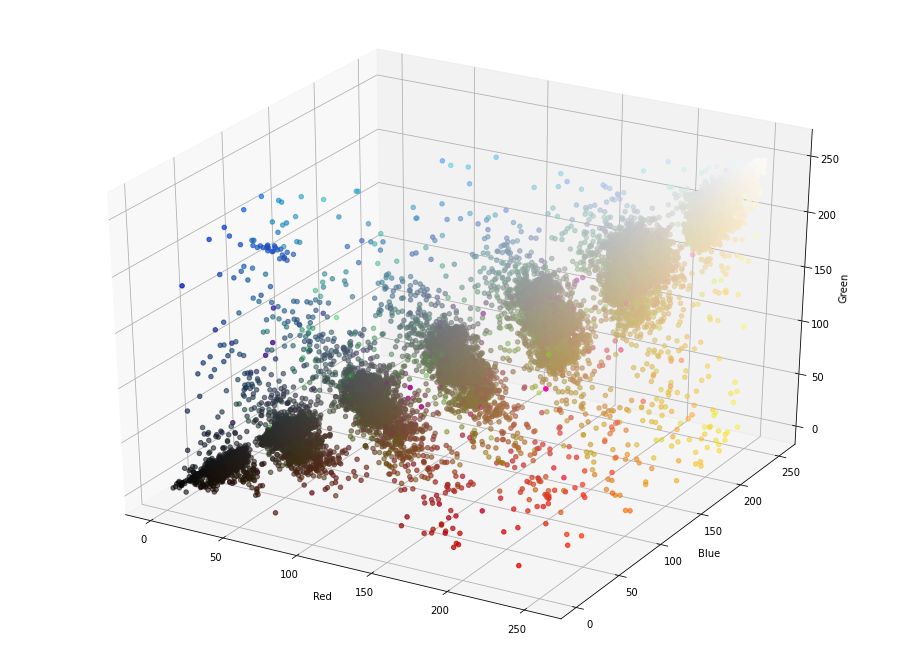

In [8]:
# pare down colors to colors that represent at least 5% of the overall artwork
color_final_df_2 = color_final_df.loc[color_final_df['fraction'] >= .05]
point_colors = color_final_df_2[['red', 'green', 'blue']].values

# plot colors
color_plot = plt.figure(figsize=[16,12]).gca(projection='3d')
color_plot.scatter(color_final_df_2['red'], color_final_df_2['green'], color_final_df_2['blue'], color=point_colors/255.0)
color_plot.set_xlabel('Red')
color_plot.set_ylabel('Blue')
color_plot.set_zlabel('Green')
plt.show()

In [0]:
import pickle
with open('pointcolors.pkl', 'wb') as f:
  pickle.dump(point_colors, f)

In [0]:
color_final_df_2.to_csv('aic_color_final_2.csv', index=None)

# Hooking things up to AWS
Now that I have a color matrix of painting colors, it's time to start working on getting color information from the user's uploaded photo and finding it's nearest neighbor.

In [0]:
def euclidean_distance(row1, row2):
  """Calculate Euclidian distance between two vectors"""
  distance = 0.0
  for i in range(len(row1)-1):
	  distance += (row1[i] - row2[i])**2
  return np.sqrt(distance)

def get_neighbors(train, test_row, num_neighbors):
  """Get nearest neighbors"""
  distances = list()
  for train_row in train:
    dist = euclidean_distance(test_row, train_row)
    distances.append((train_row, dist))
  distances.sort(key=lambda tup: tup[1])
  neighbors = list()
  for i in range(num_neighbors):
	  neighbors.append(distances[i][0])
  return neighbors

neighbors = get_neighbors(point_colors, [94, 155, 219], 3)
for neighbor in neighbors:
	print(neighbor)